# Homework 2: Infotaxis
Due April 16, 2025

## Preliminaries
A robot is moving on a 25x25 grid. At each time step the robot can move up, down, left, or right for one grid cell. There is an unknown signal source in the environment emitting signals. The robot is equipped with a binary sensor with a reading {0, 1}. The measurement model can be formulated as a Bernoulli distribution, and the likelihood of the Bernoulli distribution is specified based on the source location and the robot location.

<div style="text-align: center;">
  <img src="grid.png" alt="Grid" style="border-radius: 15px;">
</div>

The measurement model in the Infotaxis problem setup. Assuming the letter 'D' is where the signal source is, the shades and the numbers represent the likelihood of registering a sensor reading of '1' if the robot is in that region. The likelihood of registering a sensor reading of '0' is 1 - L(1)


In [388]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Use the GPU if available
DEV = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEV}")

Using device: cuda


## Robot Structure

```markdown
4 4 4 4 4 4 4
0 3 3 3 3 3 0
0 0 2 2 2 0 0
0 0 0 D 0 0 0
0 0 2 2 2 0 0
0 3 3 3 3 3 0
4 4 4 4 4 4 4
```

Where D is the signal source location and the number is the reciprocal of the likelihood of reading a 1 if the robot is in that region. For example: 3 -> (1/3) likelihood of 1 and (2/3) likelihood of reading 0.

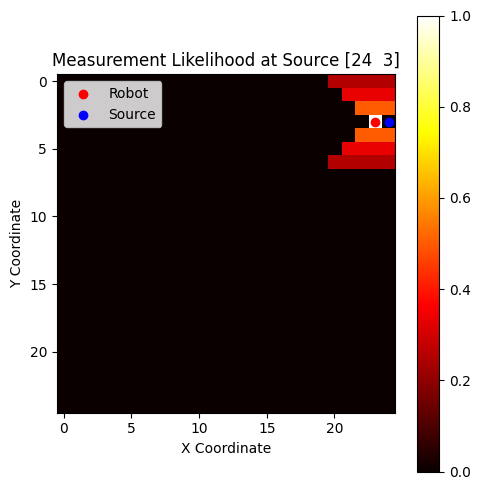

In [422]:
# Grid constants and initialization
GRID_SIZE = 25
TOTAL_CELLS = GRID_SIZE * GRID_SIZE

ACTIONS = torch.tensor(
    [
        [-1, 0],  # up
        [1, 0],  # down
        [0, -1],  # left
        [0, 1],  # right
        [0, 0]  # stay
    ],
    device=DEV,
).float()

X = torch.arange(GRID_SIZE, device=DEV).float()
Y = torch.arange(GRID_SIZE, device=DEV).float()
X, Y = torch.meshgrid(X, Y, indexing='ij')
GRID_POSITIONS = torch.stack([X.flatten(), Y.flatten()], dim=1).to(DEV)

def in_bounds(x, y):
    return (0 <= x < GRID_SIZE).item() and (0 <= y < GRID_SIZE).item()

# Create the likelihood matrix
likelihood_matrix = np.zeros((7, 7))
likelihood_matrix[3, 3] = 1.0  # Center point has the highest likelihood

for r in range(4):  # Iterate through the top half of the grid (including the middle row)
  for c in range(7):
    # Top and bottom rows are 1/4 chance of 1
    if r == 0: 
      likelihood_matrix[r, c] = 1 / 4.0
      likelihood_matrix[6 - r, c] = 1 / 4.0
    # Second row is 1/3 chance of 1
    elif r == 1 and (c != 0 and c != 6): 
      likelihood_matrix[r, c] = 1 / 3.0
      likelihood_matrix[6 - r, c] = 1 / 3.0
    # Third row is 1/2 chance of 1
    elif r == 2 and (c != 0 and c != 1 and c != 5 and c != 6):
      likelihood_matrix[r, c] = 1 / 2.0
      likelihood_matrix[6 - r, c] = 1 / 2.0
    # Center point has the highest likelihood
    elif r == 3 and c == 3:
      likelihood_matrix[r, c] = 1.0

likelihood_matrix = torch.tensor(likelihood_matrix, device=DEV).float()

# Overlay the source likelihood on the main grid to obtain the likelihood grid
def create_likelihood(source):
    # Ensure source is a long tensor for indexing
    source = source.long()

    # Overlay the source likelihood on the main grid at the given source location
    # Initialize with uniform distribution
    L = torch.ones((GRID_SIZE, GRID_SIZE), device=DEV) / TOTAL_CELLS  
    x, y = source[0], source[1]
    for r in range(7):
        for c in range(7):
            # Calculate the new coordinates based on the source location
            # Shift into top-left corner of 7x7 likelihood grid
            new_x = x - 3 + c
            new_y = y - 3 + r
            # Ensure the new coordinates are within bounds
            if in_bounds(new_x, new_y):
                L[new_y, new_x] = likelihood_matrix[r, c]
    # Normalize the likelihood grid
    L /= L.sum()
    return L

def local_measurement_likelihood(robot, source):
  dx, dy = robot[0] - (source[0] - 3), robot[1] - (source[1] - 3)
  if (0 <= dx < 7).item() and (0 <= dy < 7).item():
      return likelihood_matrix[dy.long(), dx.long()]  # Use long indexing for tensor
  else:
    return torch.tensor(1e-6, device=DEV)  # Return a small value if out of bounds

def full_measurement_likelihood(robot):
  # Initialize likelihood grid
  likelihood = torch.ones((GRID_SIZE, GRID_SIZE), device=DEV) / TOTAL_CELLS
  # Iterate over all grid positions
  for i in range(GRID_SIZE):
    for j in range(GRID_SIZE):
      # Compute likelihood for each grid position
      likelihood[j, i] = local_measurement_likelihood(robot, torch.tensor([i, j], device=DEV))
  return likelihood

s = torch.randint(0, GRID_SIZE, (2,), device=DEV)
L_debug = create_likelihood(s)
# Visualize the measurement likelihood
figure = plt.figure(figsize=(5, 5))
r = torch.randint(0, GRID_SIZE, (2,), device=DEV)
# Create a grid of robot positions
robot_positions = torch.stack(torch.meshgrid(X[:, 0], Y[0, :], indexing='ij'), dim=-1).to(DEV)

# Compute measurement likelihood for the entire grid
likelihood_grid = full_measurement_likelihood(r)

# Visualize the likelihood grid
plt.imshow(likelihood_grid.cpu().numpy(), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.scatter(r[0].cpu().numpy(), r[1].cpu().numpy(), color='red', label='Robot')
plt.scatter(s[0].cpu().numpy(), s[1].cpu().numpy(), color='blue', label='Source')
plt.title(f"Measurement Likelihood at Source {s.cpu().numpy()}")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.grid(False)
plt.legend()
plt.tight_layout()
plt.show()

def simulate_measurement(robot, source):
  return torch.bernoulli(local_measurement_likelihood(robot, source)).item()

def bayesian_update(belief, measurement, robot):
  Ls = full_measurement_likelihood(robot)
  Ls = Ls.view(GRID_SIZE, GRID_SIZE)  # Reshape to match the belief tensor shape
  if measurement == 0:
    Ls = 1 - Ls
  belief *= Ls
  belief /= belief.sum()
  return belief

## Problem 1: Exploration Strategy

Source Location: [ 1 18]
Initial Robot Location: [11 17]
Robot Location: [12. 17.], Measurement: 0.0
Robot Location: [12. 16.], Measurement: 0.0
Robot Location: [13. 16.], Measurement: 0.0
Robot Location: [14. 16.], Measurement: 0.0
Robot Location: [14. 17.], Measurement: 0.0
Robot Location: [13. 17.], Measurement: 0.0
Robot Location: [13. 17.], Measurement: 0.0
Robot Location: [13. 18.], Measurement: 0.0
Robot Location: [13. 19.], Measurement: 0.0
Robot Location: [14. 19.], Measurement: 0.0
Robot Location: [14. 18.], Measurement: 0.0
Robot Location: [14. 19.], Measurement: 0.0
Robot Location: [15. 19.], Measurement: 0.0
Robot Location: [15. 20.], Measurement: 0.0
Robot Location: [14. 20.], Measurement: 0.0
Robot Location: [14. 21.], Measurement: 0.0
Robot Location: [15. 21.], Measurement: 0.0
Robot Location: [15. 22.], Measurement: 0.0
Robot Location: [14. 22.], Measurement: 0.0
Robot Location: [14. 21.], Measurement: 0.0
Robot Location: [13. 21.], Measurement: 0.0
Robot Location: [12

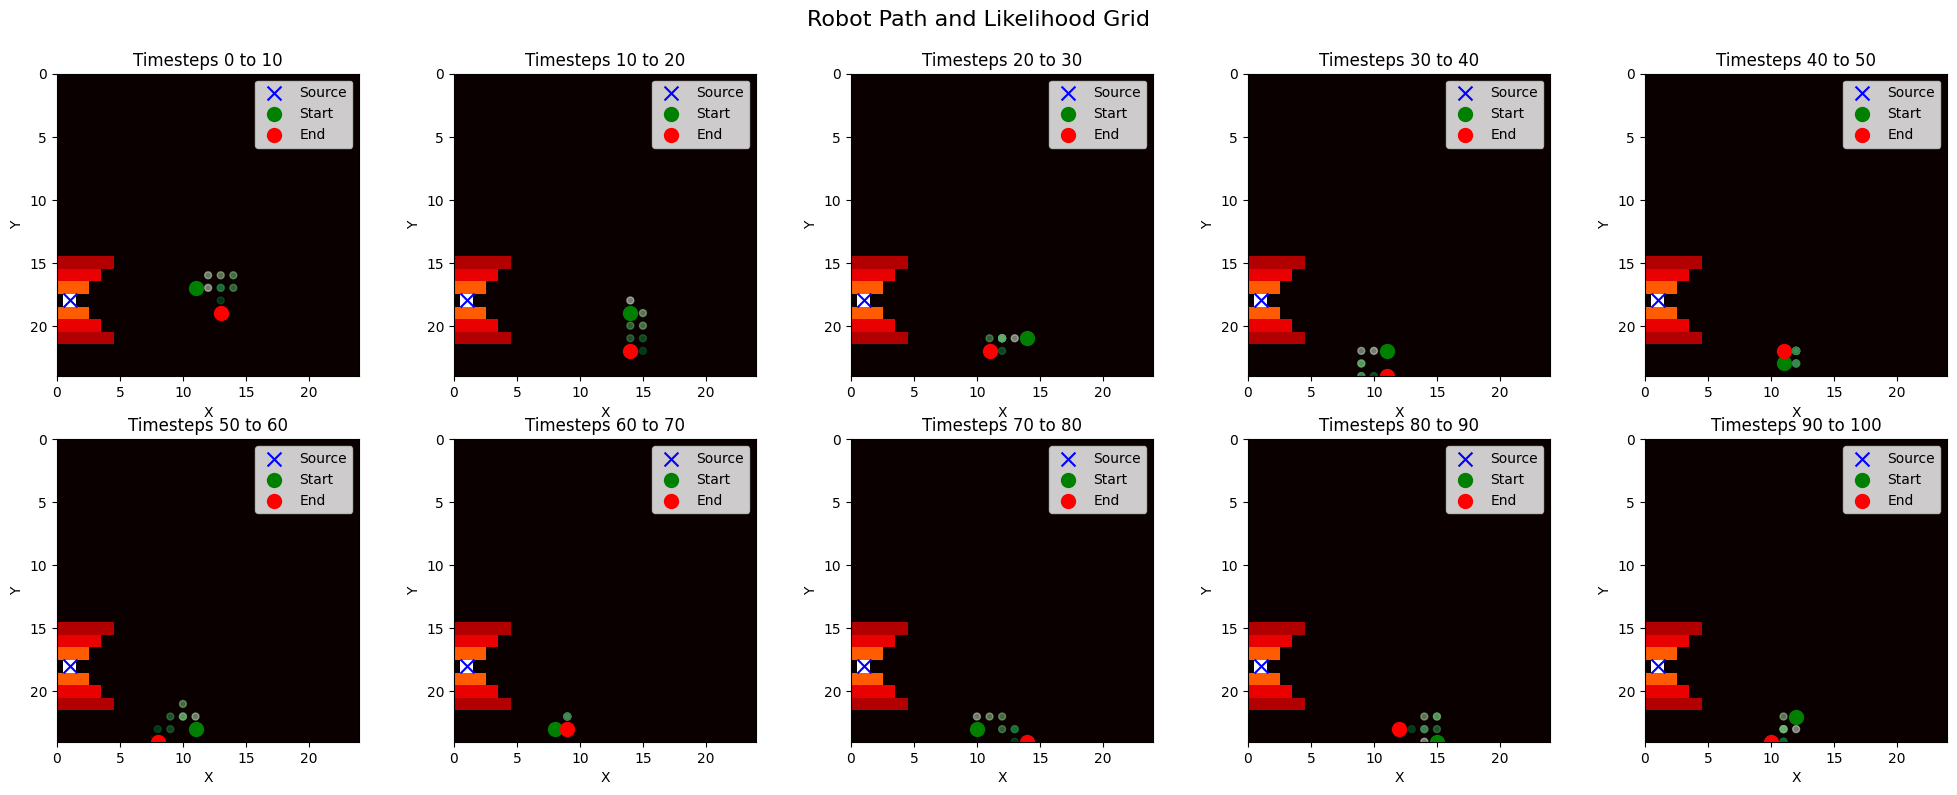

In [423]:
# Randomly sample a source location and an initial location of the robot.
source_location = torch.randint(0, GRID_SIZE, (2,), device=DEV)
robot_location = torch.randint(0, GRID_SIZE, (2,), device=DEV)
print(f"Source Location: {source_location.cpu().numpy()}")
print(f"Initial Robot Location: {robot_location.cpu().numpy()}")

NUM_TIMESTEPS = 100

def generate_robot_action(robot):
    # Randomly pick an action from the action space
    action = torch.randint(0, len(ACTIONS), (1,), device=DEV).item()
    while True:
        # Calculate the new robot location based on the action
        new_location = robot + ACTIONS[action]
        # Check if the new location is within bounds
        if in_bounds(new_location[0], new_location[1]):
            break
        else:
            # If out of bounds, pick a different action
            action = torch.randint(0, len(ACTIONS), (1,), device=DEV).item()
    # Update the robot location
    robot = new_location
    return robot

# Develop an exploration strategy, at each time step, 
# select an action (up,down, left, right, stay) to quickly explore the search space
# Move the robot according to the selected action
robot_path = [robot_location.cpu().numpy()]
L = create_likelihood(source_location)
for t in range(1, NUM_TIMESTEPS):
    # Randomly select an action for the robot
    robot_location = generate_robot_action(robot_location)
    robot_path.append(robot_location.cpu().numpy())

    # After executing each action, simulate a measurement, 
    # and use Bayesian update to update the belief of the source location.
    Z = simulate_measurement(robot_location, source_location)
    # print(f"Robot Location: {robot_location.cpu().numpy()}, Measurement: {Z}")
    L = bayesian_update(L, Z, robot_location)

print(f"Final Robot Location: {robot_location.cpu().numpy()}")
robot_path_np = np.array(robot_path)

# Visualize the likelihood grid with heatmap
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
timesteps_per_plot = NUM_TIMESTEPS // 10

for i, ax in enumerate(axes.flat):
    start = i * timesteps_per_plot
    end = (i + 1) * timesteps_per_plot
    ax.imshow(L.cpu().numpy(), cmap='hot', interpolation='nearest')
    ax.set_xlim(0, GRID_SIZE - 1)
    ax.set_ylim(GRID_SIZE - 1, 0)  # Invert y-axis to match the grid coordinates
    ax.set_aspect('equal')
    ax.scatter(source_location[0].cpu().numpy(), source_location[1].cpu().numpy(), c='blue', label='Source', marker='x', s=100)
    ax.scatter(robot_path_np[start:end, 0], robot_path_np[start:end, 1], c=np.linspace(0, 1, end - start), cmap='Greens', alpha=0.5, s=25)
    ax.scatter(robot_path_np[start, 0], robot_path_np[start, 1], c='green', label='Start', marker='o', s=100)
    ax.scatter(robot_path_np[end - 1, 0], robot_path_np[end - 1, 1], c='red', label='End', marker='o', s=100)
    ax.set_title(f'Timesteps {start} to {end}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend()
    ax.grid(False)

# Adjust layout and title
plt.tight_layout()
plt.suptitle('Robot Path and Likelihood Grid', fontsize=16)
plt.subplots_adjust(top=0.90)  # Adjust the top to make room for the title
plt.savefig("problem1.png")

## Problem 2: Infotaxis Algorithm

In [ ]:
def entropy(L):
    # Calculate the entropy of the likelihood grid
    L = L[L > 0]  # Ignore zero values
    return -torch.sum(L * torch.log(L))

In [ ]:
# Randomly sample a source location and an initial location of the robot
source_location = torch.randint(0, GRID_SIZE, (2,), device=DEV)
robot_location = torch.randint(0, GRID_SIZE, (2,), device=DEV)
print(f"Source Location: {source_location.cpu().numpy()}")
print(f"Initial Robot Location: {robot_location.cpu().numpy()}")

# Implement the Infotaxis algorithm to choose the optimal action at each time step to maximize
# the expected entropy reduction (information gain) until convergence.


Source Location: [11 22]
Initial Robot Location: [19 24]
